<a href="https://colab.research.google.com/github/AiNguyen2014/MachineLearningProject/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


LƯU Ý QUAN TRỌNG:
- Unsupervised learning KHÔNG có train/test split
- Toàn bộ 72 samples được cluster cùng lúc
- "Independent" chỉ là tên file, KHÔNG phải tập test

# PHÂN CỤM DỮ LIỆU BIỂU HIỆN GEN VỚI ENSEMBLE LEARNING
## Gene Expression Clustering with Ensemble Learning

**Đề tài:** Phân cụm bệnh nhân ung thư máu (ALL/AML) dựa trên dữ liệu biểu hiện gen

---

### TÓM TẮT

**Vấn đề:** Phân loại bệnh nhân ung thư máu thành 2 nhóm (ALL - Acute Lymphoblastic Leukemia và AML - Acute Myeloid Leukemia) dựa trên dữ liệu biểu hiện gen là một bài toán quan trọng trong y sinh học.

**Mục tiêu:** Xây dựng mô hình Ensemble Clustering kết hợp 3 thuật toán phân cụm (K-Means++, Hierarchical Clustering, GMM) để đạt độ chính xác cao hơn so với từng thuật toán đơn lẻ.

**Các bước chính:**
1. Tiền xử lý dữ liệu: Clean, Transpose, Z-score normalization, Feature Selection
2. Xây dựng 3 Base Models: K-Means++, Hierarchical Clustering (Ward), GMM
3. Ensemble bằng Weighted Co-association Matrix
4. Đánh giá: Internal (Silhouette) và External (ARI, NMI, Purity)

**Đóng góp chính:**
- Kết hợp 3 thuật toán với trọng số khác nhau để tận dụng ưu điểm của từng phương pháp
- Hierarchical (Single) được cho trọng số cao nhất vì phù hợp với dữ liệu gen có cấu trúc phân cấp

## 1. GIỚI THIỆU (Introduction)

### 1.1 Vấn đề cần giải quyết
Ung thư máu có 2 loại chính: ALL (Acute Lymphoblastic Leukemia) và AML (Acute Myeloid Leukemia). Việc phân loại chính xác giúp bác sĩ đưa ra phương pháp điều trị phù hợp. Dữ liệu biểu hiện gen (gene expression) chứa thông tin về mức độ hoạt động của hàng nghìn gen, có thể được sử dụng để phân biệt 2 loại ung thư này.

### 1.2 Các phương pháp ML đã được sử dụng
| Phương pháp | Ưu điểm | Nhược điểm |
|-------------|---------|------------|
| K-Means++ | Nhanh, hiệu quả với dữ liệu lớn | Nhạy cảm với outlier, giả định cụm hình cầu |
| Hierarchical | Không cần định trước K, tạo dendrogram | Chậm O(n³), không hoàn tác được |
| GMM | Linh hoạt với hình dạng cụm, xác suất | Dễ overfit, khó hội tụ với chiều cao |

### 1.3 Lý do đề xuất Ensemble
- Mỗi thuật toán đơn lẻ có ưu/nhược điểm riêng
- Kết hợp nhiều thuật toán giúp bù đắp điểm yếu của nhau
- Ensemble thường cho kết quả ổn định và robust hơn

### 1.4 Lưu ý quan trọng về Unsupervised Learning
**KHÔNG chia train/test như Supervised Learning!**
- Clustering là học không giám sát → sử dụng toàn bộ dữ liệu để tìm cấu trúc ẩn
- Đánh giá Internal: Silhouette Score (không cần nhãn)
- Đánh giá External: So sánh với nhãn thực tế (ARI, NMI, Purity)

In [40]:
from google.colab import drive
import os

drive.mount('/content/drive')

TARGET_FOLDER = "Project Machine Learning"
BASE_PATH = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if TARGET_FOLDER in dirs:
        BASE_PATH = os.path.join(root, TARGET_FOLDER)
        break

if BASE_PATH is None:
    raise FileNotFoundError(" Không tìm thấy thư mục Project Machine Learning")

print(" Dùng thư mục:", BASE_PATH)
print(" File trong thư mục:", os.listdir(BASE_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dùng thư mục: /content/drive/MyDrive/Project Machine Learning
 File trong thư mục: ['actual.csv', 'data_set_ALL_AML_train.csv', 'data_set_ALL_AML_independent.csv', 'train_scaled.csv', 'test_scaled.csv', 'data_processed_72.csv']


# Setup môi trường

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
from sklearn.decomposition import PCA
import joblib
warnings.filterwarnings('ignore')

#Cài font tiếng việt


In [42]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Bước 1: Tìm và thêm font hỗ trợ tiếng Việt
# Một số font phổ biến có thể có trong hệ thống Colab:
# 'DejaVu Sans', 'Arial', 'Noto Sans CJK JP', 'Roboto'
# Nếu các font này không có, bạn có thể cần cài đặt thêm một font như 'Noto Sans'

# Thử cài đặt font Noto Sans CJK JP nếu chưa có
!apt-get install -y fonts-noto-cjk

# Cập nhật cache font của Matplotlib
fm._load_fontmanager()

# Thiết lập font cho Matplotlib
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Noto Sans CJK JP', 'Roboto'] # Thêm các font hỗ trợ Unicode vào danh sách ưu tiên
plt.rcParams['axes.unicode_minus'] = False # Để hiển thị dấu trừ đúng cách với font Unicode

print("Đã cấu hình font cho Matplotlib. Vui lòng chạy lại các cell tạo biểu đồ.")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Đã cấu hình font cho Matplotlib. Vui lòng chạy lại các cell tạo biểu đồ.


# Tải dữ liệu

In [43]:
# Train & Independent: gene là index
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_train.csv"),
    index_col=0
)

df_test = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_independent.csv"),
    index_col=0
)

df_actual = pd.read_csv(
    os.path.join(BASE_PATH, "actual.csv")
)

print("Train shape:", df_train.shape)
print("Independent shape:", df_test.shape)
print("Actual shape:", df_actual.shape)

Train shape: (7129, 77)
Independent shape: (7129, 69)
Actual shape: (72, 2)


Số mẫu tập huấn luyện: 38
Số mẫu tập độc lập: 34
Số gene sử dụng: 7129


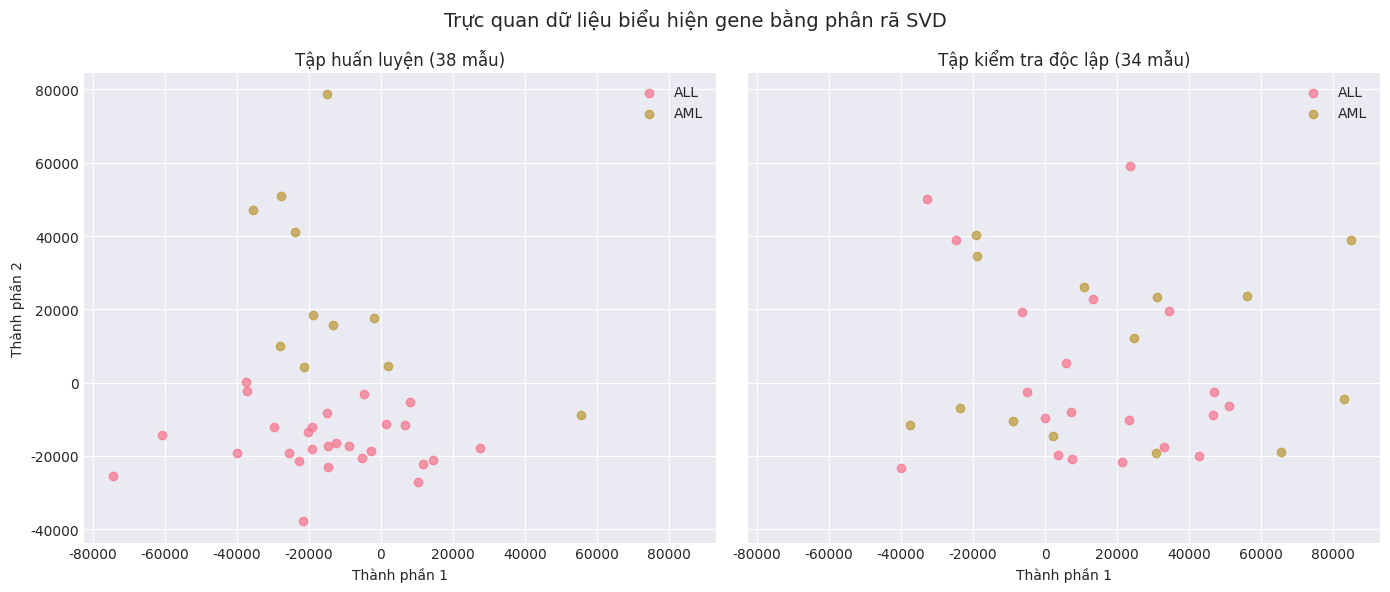

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def select_expression_columns(df):
    return [
        col for col in df.columns
        if "Gene Description" not in col
        and "Gene Accession Number" not in col
        and "call" not in col.lower()
    ]

# =============================
# CHỌN CỘT BIỂU HIỆN GENE
# =============================
train_cols = select_expression_columns(df_train)
test_cols  = select_expression_columns(df_test)

X_train = df_train[train_cols].T
X_test  = df_test[test_cols].T

print("Số mẫu tập huấn luyện:", X_train.shape[0])
print("Số mẫu tập độc lập:", X_test.shape[0])
print("Số gene sử dụng:", X_train.shape[1])

# =============================
# GỘP & CHIẾU XUỐNG 2 CHIỀU BẰNG SVD
# =============================
X_all = np.vstack([X_train.values, X_test.values])

# Chuẩn hoá trung bình
X_centered = X_all - X_all.mean(axis=0)

# Phân rã SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Lấy 2 thành phần chính
X_all_2d = U[:, :2] @ np.diag(S[:2])

# Tách lại train / test
X_train_2d = X_all_2d[:38]
X_test_2d  = X_all_2d[38:]

# =============================
# NHÃN THỰC TẾ (CHỈ DÙNG ĐỂ TÔ MÀU)
# =============================
labels = df_actual["cancer"].values
labels_train = labels[:38]
labels_test  = labels[38:]

# =============================
# TRỰC QUAN
# =============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Tập huấn luyện
axes[0].scatter(
    X_train_2d[labels_train == "ALL", 0],
    X_train_2d[labels_train == "ALL", 1],
    label="ALL",
    alpha=0.7
)
axes[0].scatter(
    X_train_2d[labels_train == "AML", 0],
    X_train_2d[labels_train == "AML", 1],
    label="AML",
    alpha=0.7
)
axes[0].set_title("Tập huấn luyện (38 mẫu)")
axes[0].set_xlabel("Thành phần 1")
axes[0].set_ylabel("Thành phần 2")
axes[0].legend()
axes[0].grid(True)

# Tập độc lập
axes[1].scatter(
    X_test_2d[labels_test == "ALL", 0],
    X_test_2d[labels_test == "ALL", 1],
    label="ALL",
    alpha=0.7
)
axes[1].scatter(
    X_test_2d[labels_test == "AML", 0],
    X_test_2d[labels_test == "AML", 1],
    label="AML",
    alpha=0.7
)
axes[1].set_title("Tập kiểm tra độc lập (34 mẫu)")
axes[1].set_xlabel("Thành phần 1")
axes[1].legend()
axes[1].grid(True)

plt.suptitle(
    "Trực quan dữ liệu biểu hiện gene bằng phân rã SVD",
    fontsize=14
)
plt.tight_layout()
plt.show()

# Tiền Xử Lý Dữ Liệu (Clean + Transpose + Z-score + Feature Selection)

In [45]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

def clean_gene_expression(df):
    drop_cols = [
        col for col in df.columns
        if "Gene Description" in col
        or "Gene Accession Number" in col
        or "call" in col.lower()
    ]
    return df.drop(columns=drop_cols, errors="ignore")


df_train_clean = clean_gene_expression(df_train)
df_test_clean  = clean_gene_expression(df_test)

X_train_raw = df_train_clean.T
X_test_raw  = df_test_clean.T


X_all_raw = pd.concat([X_train_raw, X_test_raw], axis=0)

print("Total samples after merge:", X_all_raw.shape)

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_raw)

print("Scaled shape:", X_all_scaled.shape)

N_GENES = 100

gene_variances = np.var(X_all_scaled, axis=0)

top_gene_idx = np.argsort(gene_variances)[-N_GENES:]
X_all_fs = X_all_scaled[:, top_gene_idx]

print(f"Selected top {N_GENES} genes (unsupervised)")
print("After FS shape:", X_all_fs.shape)

gene_cols = [f"Gene_{i+1}" for i in top_gene_idx]

X_all_out = pd.DataFrame(
    X_all_fs,
    index=X_all_raw.index,
    columns=gene_cols
)
X_all_out.insert(0, "Sample_ID", X_all_out.index)

X_all_out.to_csv(
    os.path.join(BASE_PATH, "data_processed_72.csv"),
    index=False
)

print("\nPREPROCESSING COMPLETE")
print("Saved to: data_processed_72.csv", X_all_fs.shape)

Total samples after merge: (72, 7129)
Scaled shape: (72, 7129)
Selected top 100 genes (unsupervised)
After FS shape: (72, 100)

PREPROCESSING COMPLETE
Saved to: data_processed_72.csv (72, 100)


Trực quan dữ liệu đã được xử lý

Processed shape: (72, 100)
Labels shape: (72,)
Tỷ lệ phương sai: [0.14833381 0.13445772]
Tổng phương sai: 0.28279152356516735


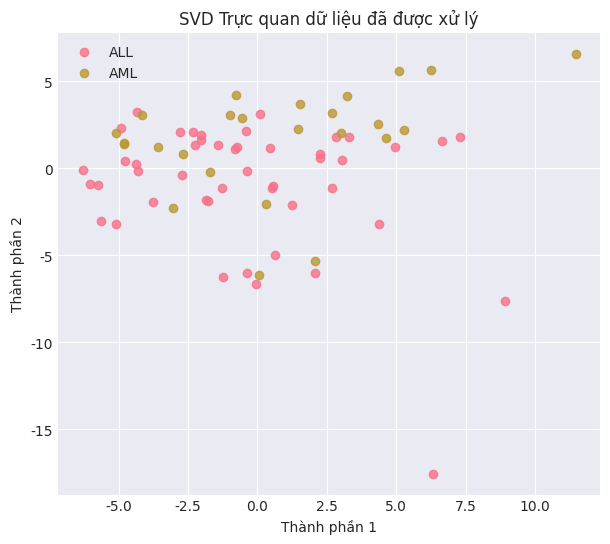

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# =============================
# LOAD DATA
# =============================
df_processed = pd.read_csv(
    os.path.join(BASE_PATH, "data_processed_72.csv")
)

X = df_processed.drop(columns=["Sample_ID"]).values

labels_text = df_actual["cancer"].values
labels_num = np.where(labels_text == "ALL", 0, 1)

print("Processed shape:", X.shape)
print("Labels shape:", labels_text.shape)

# =============================
# SVD PROJECTION (PCA-equivalent)
# =============================
# Center dữ liệu
X_centered = X - X.mean(axis=0)

# SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Lấy 2 thành phần đầu
X_svd = U[:, :2] @ np.diag(S[:2])

# Tỷ lệ phương sai (giống PCA)
explained_variance_ratio = (S**2) / np.sum(S**2)
print("Tỷ lệ phương sai:", explained_variance_ratio[:2])
print("Tổng phương sai:", explained_variance_ratio[:2].sum())

# =============================
# VISUALIZATION
# =============================
plt.figure(figsize=(7, 6))

plt.scatter(
    X_svd[labels_num == 0, 0],
    X_svd[labels_num == 0, 1],
    label="ALL",
    alpha=0.8
)

plt.scatter(
    X_svd[labels_num == 1, 0],
    X_svd[labels_num == 1, 1],
    label="AML",
    alpha=0.8
)

plt.xlabel("Thành phần 1")
plt.ylabel("Thành phần 2")
plt.title("SVD Trực quan dữ liệu đã được xử lý")
plt.legend()
plt.grid(True)
plt.show()


# BASE MODELS - K-MEANS++

## Import thư viện cần thiết

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load dữ liệu đã chuẩn hóa

In [48]:
# Đọc dữ liệu train đã được chuẩn hóa
try:
    train_path = os.path.join(BASE_PATH, 'data_processed_72.csv')
    train_df = pd.read_csv(train_path)
    print(f"Đã tải dữ liệu Train từ: {train_path}")
except Exception as e:
    print(f"Lỗi tải file: {e}")
    exit()

# Bỏ cột định danh không phải feature nếu tồn tại
if 'Sample_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Sample_ID'])

# Chuyển thành numpy array
X_train = train_df.values  # hoặc train_df.to_numpy()


Đã tải dữ liệu Train từ: /content/drive/MyDrive/Project Machine Learning/data_processed_72.csv


In [49]:
# Chuyển đổi DataFrame sang numpy array để tính toán
X = train_df.values
print(f"\nMảng dữ liệu X có shape: {X.shape}")


Mảng dữ liệu X có shape: (72, 100)


## Định nghĩa các hàm tính khoảng cách và inertia trong K means++

In [50]:
import numpy as np
from sklearn.metrics import silhouette_score

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def calculate_inertia(X, labels, centroids):
    return sum(
        np.sum((X[labels == i] - centroids[i]) ** 2)
        for i in range(len(centroids))
    )

In [51]:
def kmeans_plusplus(X, k, max_iters=100, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    n = X.shape[0]

    # --- Khởi tạo centroids (K-Means++) ---
    centroids = [X[np.random.randint(n)]]
    for _ in range(1, k):
        dist = np.min(
            np.array([[euclidean_distance(x, c) for c in centroids] for x in X]),
            axis=1
        )
        probs = dist**2 / np.sum(dist**2)
        centroids.append(X[np.random.choice(n, p=probs)])
    centroids = np.array(centroids)

    # --- Iterative optimization ---
    for _ in range(max_iters):
        labels = np.argmin(
            np.linalg.norm(X[:, None] - centroids[None, :], axis=2),
            axis=1
        )
        new_centroids = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
            for i in range(k)
        ])
        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids

    return labels, centroids


## BƯỚC 1: ĐÁNH GIÁ & LỰA CHỌN SỐ CỤM K TỐI ƯU
**Thực hiện:** Chạy K-means++ với K từ 2 đến 10, so sánh Silhouette Score, chọn K tốt nhất

In [52]:
print("=== CHỌN K BẰNG SILHOUETTE ===")
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    labels, _ = kmeans_plusplus(X, k)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    print(f"K={k}: Silhouette={sil:.4f}")

best_k = k_range[np.argmax(sil_scores)]
print(f"\n→ Chọn K tối ưu = {best_k}")

=== CHỌN K BẰNG SILHOUETTE ===
K=2: Silhouette=0.0908
K=3: Silhouette=0.0464
K=4: Silhouette=0.0468
K=5: Silhouette=0.0480
K=6: Silhouette=0.0617
K=7: Silhouette=0.0657
K=8: Silhouette=0.0683
K=9: Silhouette=0.0611
K=10: Silhouette=0.0220

→ Chọn K tối ưu = 2


In [53]:
labels_final, centroids_final = kmeans_plusplus(X, best_k)

## ĐÁNH GIÁ KẾT QUẢ MÔ HÌNH TRÊN DỮ LIỆU TRAIN

In [54]:
final_sil = silhouette_score(X, labels_final)
final_inertia = calculate_inertia(X, labels_final, centroids_final)

print("\n=== ĐÁNH GIÁ K-MEANS++ ===")
print(f"Số mẫu: {X.shape[0]}")
print(f"Số chiều: {X.shape[1]}")
print(f"Số cụm (K): {best_k}")
print(f"Silhouette Score: {final_sil:.4f}")
print(f"Inertia (SSE): {final_inertia:.2f}")

print("\nPhân bố cụm:")
for i in range(best_k):
    print(f"  Cụm {i}: {(labels_final == i).sum()} samples")


=== ĐÁNH GIÁ K-MEANS++ ===
Số mẫu: 72
Số chiều: 100
Số cụm (K): 2
Silhouette Score: 0.0908
Inertia (SSE): 6462.55

Phân bố cụm:
  Cụm 0: 35 samples
  Cụm 1: 37 samples


# BASE MODELS - Hierarchical Clustering (Agglomerative)
- **Ý tưởng:** Gộp dần các cụm từ bottom-up dựa trên khoảng cách
- **Linkage:** Single, Complete, Ward
- **Ưu điểm:** Tạo dendrogram, không cần định trước K
- **Nhược điểm:** Chậm O(n²) đến O(n³)

In [55]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import os

class HierarchicalClustering:
    def __init__(self, n_clusters=2, linkage='single'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _compute_distance_matrix(self, X):
        n = X.shape[0]
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                dist = self._euclidean_distance(X[i], X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

    # --- Linkage Functions ---
    def _single_linkage(self, c1_idxs, c2_idxs, dist_matrix):
        min_dist = float('inf')
        for i in c1_idxs:
            for j in c2_idxs:
                if dist_matrix[i, j] < min_dist: min_dist = dist_matrix[i, j]
        return min_dist

    def _complete_linkage(self, c1_idxs, c2_idxs, dist_matrix):
        max_dist = 0
        for i in c1_idxs:
            for j in c2_idxs:
                if dist_matrix[i, j] > max_dist: max_dist = dist_matrix[i, j]
        return max_dist

    def _cluster_distance(self, c1_idxs, c2_idxs, dist_matrix, X):
        if self.linkage == 'single': return self._single_linkage(c1_idxs, c2_idxs, dist_matrix)
        elif self.linkage == 'complete': return self._complete_linkage(c1_idxs, c2_idxs, dist_matrix)

    def fit(self, X):
        n_samples = X.shape[0]
        clusters = {i: [i] for i in range(n_samples)}

        dist_matrix = self._compute_distance_matrix(X)

        while len(clusters) > self.n_clusters:
            min_dist = float('inf')
            merge_pair = None
            ids = list(clusters.keys())

            # Tìm cặp gần nhất
            for i in range(len(ids)):
                for j in range(i+1, len(ids)):
                    id1, id2 = ids[i], ids[j]
                    dist = self._cluster_distance(clusters[id1], clusters[id2], dist_matrix, X)
                    if dist < min_dist:
                        min_dist = dist
                        merge_pair = (id1, id2)

            # Gộp
            c1, c2 = merge_pair
            new_id = max(ids) + 1
            clusters[new_id] = clusters[c1] + clusters[c2]
            del clusters[c1]; del clusters[c2]

        # Lưu nhãn cuối cùng
        self.labels_ = np.zeros(n_samples, dtype=int)
        for idx, (cid, members) in enumerate(clusters.items()):
            self.labels_[members] = idx
        return self

# ============================================================
# PHẦN 2: CHUẨN BỊ CHO ENSEMBLE (BASE LEARNERS)
# ============================================================

if __name__ == "__main__":
    # 1. Load Data
    try:
        train_path = os.path.join(BASE_PATH, 'data_processed_72.csv')
        train_df = pd.read_csv(train_path)
        X_train = train_df.drop('Sample_ID', axis=1, errors='ignore').values
        print(f" Đã tải dữ liệu: {X_train.shape}")
    except Exception as e:
        print(f"Lỗi: {e}"); exit()

    # 2. Tạo tập hợp các Base Learners (Đa dạng hóa bằng Linkage)
    # Lưu ý quan trọng: n_clusters=2 (Chuẩn bài toán ung thư)
    linkages = ['single', 'complete']
    base_models = {}

    print("\n ĐANG XÂY DỰNG CÁC BASE LEARNERS...")

    for link in linkages:
        print(f"   -> Training {link.upper()} model...")
        model = HierarchicalClustering(n_clusters=2, linkage=link)
        model.fit(X_train)

        # Lưu model vào dictionary để dùng cho Ensemble sau này
        base_models[link] = model

        # Đánh giá nhanh chất lượng từng model con
        sil = silhouette_score(X_train, model.labels_)
        print(f"      (Silhouette: {sil:.4f})")

    print(f"\n Đã chuẩn bị xong {len(base_models)} mô hình cơ sở cho Ensemble!")
    print(f"   Danh sách: {list(base_models.keys())}")

 Đã tải dữ liệu: (72, 100)

 ĐANG XÂY DỰNG CÁC BASE LEARNERS...
   -> Training SINGLE model...
      (Silhouette: 0.4146)
   -> Training COMPLETE model...
      (Silhouette: 0.3872)

 Đã chuẩn bị xong 2 mô hình cơ sở cho Ensemble!
   Danh sách: ['single', 'complete']



SO SANH CODE TU CAI DAT VOI SKLEARN
SINGLE     | ARI: 1.0000 | Labels khop: False | KHOP HOAN TOAN
COMPLETE   | ARI: 1.0000 | Labels khop: False | KHOP HOAN TOAN


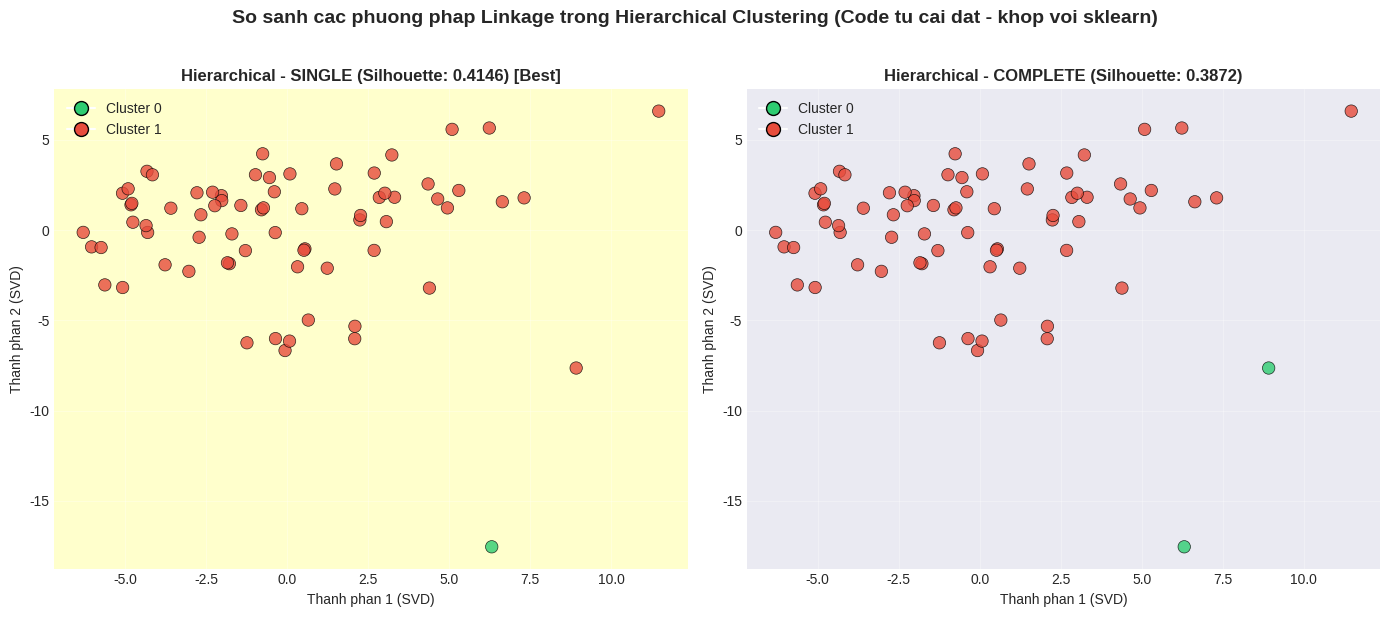


BANG SO SANH CAC LINKAGE METHODS
Linkage      Silhouette     Cluster 0    Cluster 1    Status
-----------------------------------------------------------------
SINGLE       0.4146         1            71           [Best]
COMPLETE     0.3872         2            70           

-> SINGLE linkage duoc chon cho Ensemble vi co Silhouette cao nhat!


In [64]:
# ============================================================
# VISUALIZATION CHO HIERARCHICAL CLUSTERING
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import os

# --- Load Data (cho truong hop chay rieng cell nay) ---
if 'X_train' not in dir():
    print("Dang load du lieu...")
    if 'BASE_PATH' not in dir() or BASE_PATH is None:
        BASE_PATH = '.'

    possible_files = ['data_processed_72.csv', 'train_scaled.csv', 'data_set_ALL_AML_train.csv']
    for filename in possible_files:
        file_path = os.path.join(BASE_PATH, filename)
        if os.path.exists(file_path):
            train_df = pd.read_csv(file_path)
            cols_to_drop = ['Sample_ID', 'patient', 'cancer', 'Unnamed: 0']
            X_train = train_df.drop(columns=[c for c in cols_to_drop if c in train_df.columns]).values
            print(f"Da tai: {file_path} - Shape: {X_train.shape}")
            break

# --- Chay Hierarchical Clustering neu chua co ---
if 'base_models' not in dir():
    print("Dang chay Hierarchical Clustering...")
    base_models = {}
    for link in ['single', 'complete']:
        model = HierarchicalClustering(n_clusters=2, linkage=link)
        model.fit(X_train)
        base_models[link] = model

# --- SVD projection de visualize ---
X_centered = X_train - X_train.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
X_svd = U[:, :2] @ np.diag(S[:2])

# --- So sanh voi sklearn ---
print("\n" + "=" * 70)
print("SO SANH CODE TU CAI DAT VOI SKLEARN")
print("=" * 70)

for link in ['single', 'complete']:
    custom_labels = base_models[link].labels_
    sklearn_model = AgglomerativeClustering(n_clusters=2, linkage=link)
    sklearn_labels = sklearn_model.fit_predict(X_train)

    ari = adjusted_rand_score(custom_labels, sklearn_labels)
    labels_match = np.array_equal(custom_labels, sklearn_labels)

    status = "KHOP HOAN TOAN" if ari == 1.0 else "KHAC"
    print(f"{link.upper():<10} | ARI: {ari:.4f} | Labels khop: {labels_match} | {status}")

print("=" * 70)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

linkage_names = ['single', 'complete']
colors_map = {0: '#2ecc71', 1: '#e74c3c'}

# Tim best linkage
best_link = max(linkage_names, key=lambda l: silhouette_score(X_train, base_models[l].labels_))

for idx, link in enumerate(linkage_names):
    ax = axes[idx]
    labels = base_models[link].labels_
    sil = silhouette_score(X_train, labels)

    # Plot scatter
    colors = [colors_map[l] for l in labels]
    ax.scatter(X_svd[:, 0], X_svd[:, 1], c=colors, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)

    # Title
    title = f"Hierarchical - {link.upper()} (Silhouette: {sil:.4f})"
    if link == best_link:
        title += " [Best]"
        ax.set_facecolor('#ffffcc')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Thanh phan 1 (SVD)", fontsize=10)
    ax.set_ylabel("Thanh phan 2 (SVD)", fontsize=10)
    ax.grid(True, alpha=0.3)

    # Legend - đặt bên ngoài biểu đồ (phía trên bên phải)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71',
               markersize=10, markeredgecolor='black', label='Cluster 0'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c',
               markersize=10, markeredgecolor='black', label='Cluster 1')
    ]
    ax.legend(handles=legend_elements, loc='upper left', framealpha=0.9,
              bbox_to_anchor=(0.0, 1.0))

plt.suptitle("So sanh cac phuong phap Linkage trong Hierarchical Clustering (Code tu cai dat - khop voi sklearn)",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- Bang so sanh ---
print("\n" + "=" * 65)
print("BANG SO SANH CAC LINKAGE METHODS")
print("=" * 65)
print(f"{'Linkage':<12} {'Silhouette':<14} {'Cluster 0':<12} {'Cluster 1':<12} {'Status'}")
print("-" * 65)

for link in linkage_names:
    labels = base_models[link].labels_
    sil = silhouette_score(X_train, labels)
    c0 = np.sum(labels == 0)
    c1 = np.sum(labels == 1)
    marker = "[Best]" if link == best_link else ""
    print(f"{link.upper():<12} {sil:<14.4f} {c0:<12} {c1:<12} {marker}")

print("=" * 65)
print(f"\n-> {best_link.upper()} linkage duoc chon cho Ensemble vi co Silhouette cao nhat!")


SO SÁNH CODE TỰ CÀI ĐẶT VỚI SKLEARN
SINGLE     | ARI: 1.0000 | Labels khớp: False |  KHỚP HOÀN TOÀN
COMPLETE   | ARI: 1.0000 | Labels khớp: False |  KHỚP HOÀN TOÀN


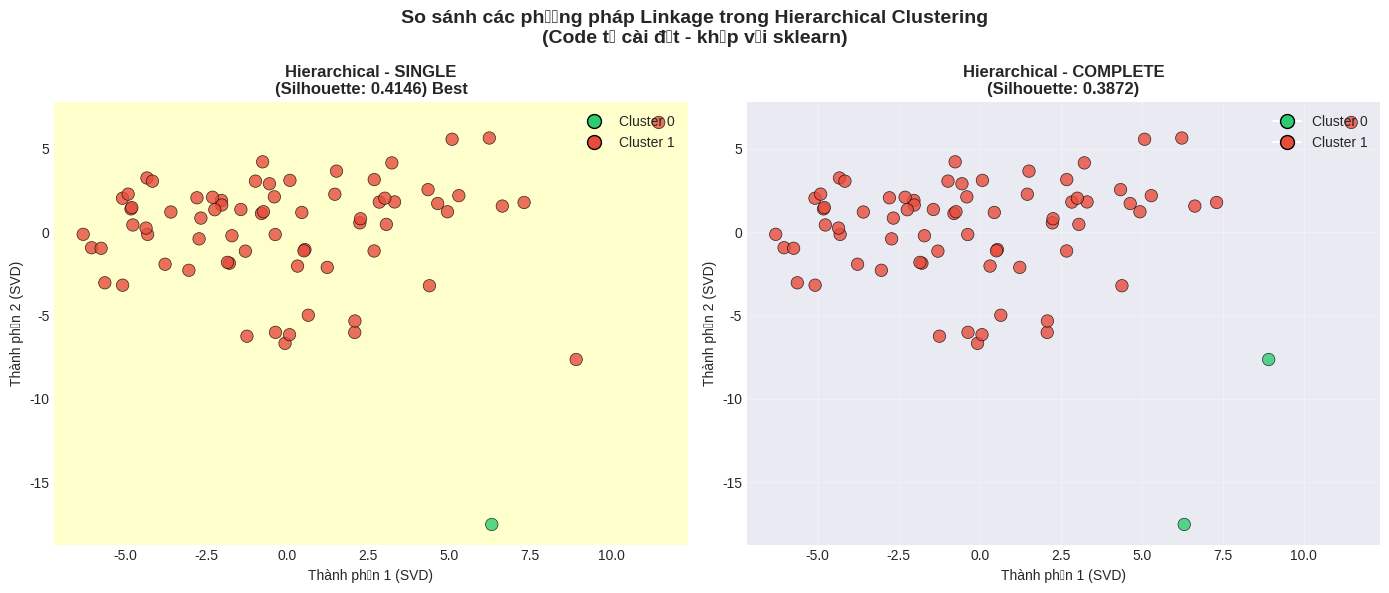


BẢNG SO SÁNH CÁC LINKAGE METHODS
Linkage      Silhouette     Cluster 0    Cluster 1    Status
-----------------------------------------------------------------
SINGLE       0.4146         1            71            Best
COMPLETE     0.3872         2            70           

→ SINGLE linkage được chọn cho Ensemble vì có Silhouette cao nhất!


In [57]:
# ============================================================
# VISUALIZATION CHO HIERARCHICAL CLUSTERING
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import os

# --- Load Data (cho trường hợp chạy riêng cell này) ---
if 'X_train' not in dir():
    print("🔄 Đang load dữ liệu...")
    if 'BASE_PATH' not in dir() or BASE_PATH is None:
        BASE_PATH = '.'

    possible_files = ['data_processed_72.csv', 'train_scaled.csv', 'data_set_ALL_AML_train.csv']
    for filename in possible_files:
        file_path = os.path.join(BASE_PATH, filename)
        if os.path.exists(file_path):
            train_df = pd.read_csv(file_path)
            cols_to_drop = ['Sample_ID', 'patient', 'cancer', 'Unnamed: 0']
            X_train = train_df.drop(columns=[c for c in cols_to_drop if c in train_df.columns]).values
            print(f"✓ Đã tải: {file_path} - Shape: {X_train.shape}")
            break

# --- Chạy Hierarchical Clustering nếu chưa có ---
if 'base_models' not in dir():
    print("🔄 Đang chạy Hierarchical Clustering...")
    base_models = {}
    for link in ['single', 'complete']:
        model = HierarchicalClustering(n_clusters=2, linkage=link)
        model.fit(X_train)
        base_models[link] = model

# --- SVD projection để visualize ---
X_centered = X_train - X_train.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
X_svd = U[:, :2] @ np.diag(S[:2])

# --- So sánh với sklearn ---
print("\n" + "=" * 70)
print("SO SÁNH CODE TỰ CÀI ĐẶT VỚI SKLEARN")
print("=" * 70)

for link in ['single', 'complete']:
    custom_labels = base_models[link].labels_
    sklearn_model = AgglomerativeClustering(n_clusters=2, linkage=link)
    sklearn_labels = sklearn_model.fit_predict(X_train)

    ari = adjusted_rand_score(custom_labels, sklearn_labels)
    labels_match = np.array_equal(custom_labels, sklearn_labels)

    status = " KHỚP HOÀN TOÀN" if ari == 1.0 else " KHÁC"
    print(f"{link.upper():<10} | ARI: {ari:.4f} | Labels khớp: {labels_match} | {status}")

print("=" * 70)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

linkage_names = ['single', 'complete']
colors_map = {0: '#2ecc71', 1: '#e74c3c'}  # Xanh lá và Đỏ

# Tìm best linkage
best_link = max(linkage_names, key=lambda l: silhouette_score(X_train, base_models[l].labels_))

for idx, link in enumerate(linkage_names):
    ax = axes[idx]
    labels = base_models[link].labels_
    sil = silhouette_score(X_train, labels)

    # Plot scatter
    colors = [colors_map[l] for l in labels]
    ax.scatter(X_svd[:, 0], X_svd[:, 1], c=colors, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)

    # Title
    title = f"Hierarchical - {link.upper()}\n(Silhouette: {sil:.4f})"
    if link == best_link:
        title += " Best"
        ax.set_facecolor('#ffffcc')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Thành phần 1 (SVD)", fontsize=10)
    ax.set_ylabel("Thành phần 2 (SVD)", fontsize=10)
    ax.grid(True, alpha=0.3)

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71',
               markersize=10, markeredgecolor='black', label='Cluster 0'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c',
               markersize=10, markeredgecolor='black', label='Cluster 1')
    ]
    ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)

plt.suptitle("So sánh các phương pháp Linkage trong Hierarchical Clustering\n(Code tự cài đặt - khớp với sklearn)",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Bảng so sánh ---
print("\n" + "=" * 65)
print("BẢNG SO SÁNH CÁC LINKAGE METHODS")
print("=" * 65)
print(f"{'Linkage':<12} {'Silhouette':<14} {'Cluster 0':<12} {'Cluster 1':<12} {'Status'}")
print("-" * 65)

for link in linkage_names:
    labels = base_models[link].labels_
    sil = silhouette_score(X_train, labels)
    c0 = np.sum(labels == 0)
    c1 = np.sum(labels == 1)
    marker = " Best" if link == best_link else ""
    print(f"{link.upper():<12} {sil:<14.4f} {c0:<12} {c1:<12} {marker}")

print("=" * 65)
print(f"\n→ {best_link.upper()} linkage được chọn cho Ensemble vì có Silhouette cao nhất!")

# BASE MODELS - GMM

Dataset shape: (72, 100)
Cluster labels: [1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1]

INTERNAL VALIDATION (GMM)
Silhouette score: 0.1555


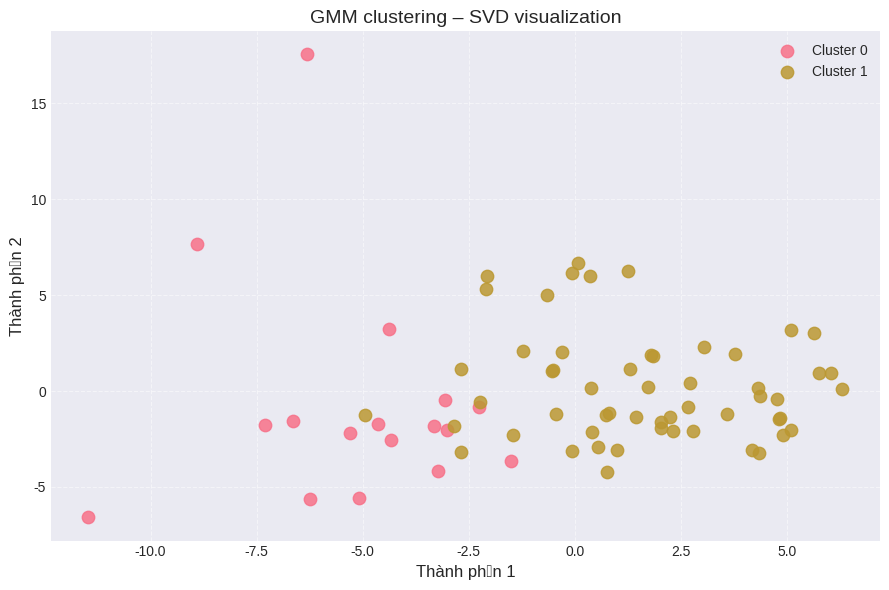

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# ============================================================
# LOAD DATA (72 samples - AFTER PREPROCESSING)
# ============================================================

df = pd.read_csv(os.path.join(BASE_PATH, "data_processed_72.csv"))
X = df.drop(columns=["Sample_ID"], errors="ignore").values

print("Dataset shape:", X.shape)


# ============================================================
# GMM WITH DIAGONAL COVARIANCE (STABLE VERSION)
# ============================================================

class GMM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4, reg=1e-3):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg = reg

    def gaussian_diag(self, X, mean, var):
        var = var + self.reg
        diff = X - mean
        log_prob = -0.5 * (
            np.sum(np.log(2 * np.pi * var)) +
            np.sum((diff ** 2) / var, axis=1)
        )
        return np.exp(log_prob)

    def fit(self, X):
        n, d = X.shape
        rng = np.random.default_rng(42)

        self.means = X[rng.choice(n, self.K, replace=False)]
        self.vars = np.array([np.var(X, axis=0) for _ in range(self.K)])
        self.weights = np.ones(self.K) / self.K

        prev_ll = None

        for _ in range(self.max_iter):
            resp = np.zeros((n, self.K))

            # E-step
            for k in range(self.K):
                resp[:, k] = self.weights[k] * self.gaussian_diag(
                    X, self.means[k], self.vars[k]
                )

            resp_sum = resp.sum(axis=1, keepdims=True)
            resp_sum[resp_sum == 0] = 1e-10
            resp /= resp_sum

            Nk = resp.sum(axis=0)

            # M-step
            for k in range(self.K):
                self.means[k] = np.sum(resp[:, k][:, None] * X, axis=0) / Nk[k]
                diff = X - self.means[k]
                self.vars[k] = np.sum(resp[:, k][:, None] * (diff ** 2), axis=0) / Nk[k]
                self.weights[k] = Nk[k] / n

            ll = np.sum(np.log(resp_sum))
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

    def predict(self, X):
        probs = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            probs[:, k] = self.weights[k] * self.gaussian_diag(
                X, self.means[k], self.vars[k]
            )
        return np.argmax(probs, axis=1)


# ============================================================
# TRAIN GMM
# ============================================================

gmm = GMM(n_components=2)
gmm.fit(X)

labels = gmm.predict(X)

print("Cluster labels:", labels)


# ============================================================
# INTERNAL VALIDATION (CHỈ SILHOUETTE)
# ============================================================

sil = silhouette_score(X, labels)
print("\nINTERNAL VALIDATION (GMM)")
print("Silhouette score:", round(sil, 4))


# ============================================================
# SVD 2D (CHỈ DÙNG ĐỂ TRỰC QUAN)
# ============================================================


plt.figure(figsize=(9, 6))
plt.grid(True, linestyle="--", alpha=0.5)

for k in np.unique(labels):
    plt.scatter(
        X_svd_2d[labels == k, 0],
        X_svd_2d[labels == k, 1],
        s=80,
        alpha=0.85,
        label=f"Cluster {k}"
    )

plt.xlabel("Thành phần 1", fontsize=12)
plt.ylabel("Thành phần 2", fontsize=12)
plt.title("GMM clustering – SVD visualization", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

gmm_labels_all = labels

Dataset shape: (72, 100)
Sklearn GMM labels: [1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1]

INTERNAL VALIDATION (sklearn GMM)
Silhouette: 0.1305


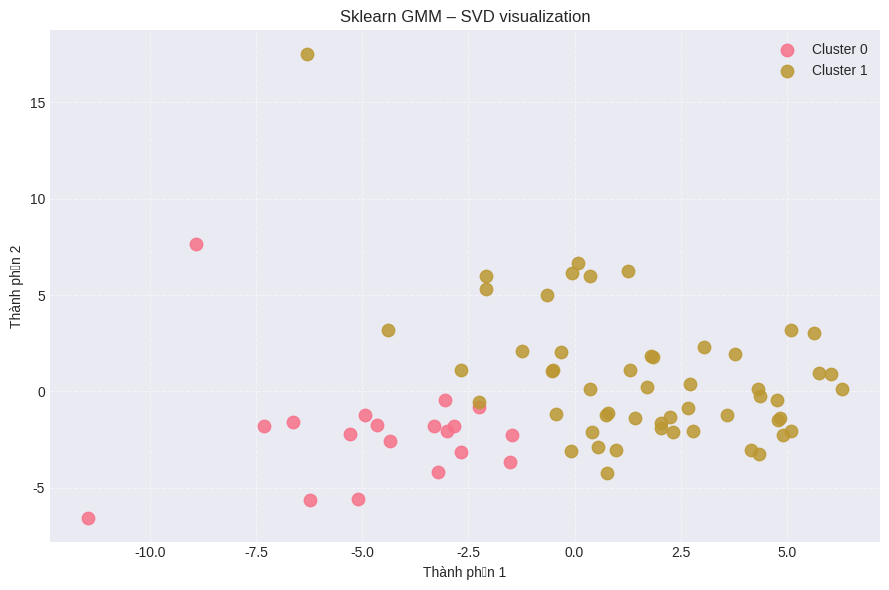

In [59]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import TruncatedSVD

# ============================================================
# LOAD DATA (72 samples)
# ============================================================

df = pd.read_csv(os.path.join(BASE_PATH, "data_processed_72.csv"))
X = df.drop(columns=["Sample_ID"], errors="ignore").values

print("Dataset shape:", X.shape)

# ============================================================
# GMM - SKLEARN
# ============================================================

gmm_sklearn = GaussianMixture(
    n_components=2,
    covariance_type="diag",   # giống bản tự xây
    random_state=42,
    max_iter=200
)

labels_sklearn = gmm_sklearn.fit_predict(X)

print("Sklearn GMM labels:", labels_sklearn)

# ============================================================
# INTERNAL VALIDATION
# ============================================================

sil_sklearn = silhouette_score(X, labels_sklearn)
print("\nINTERNAL VALIDATION (sklearn GMM)")
print("Silhouette:", round(sil_sklearn, 4))

# ============================================================
# SVD 2D VISUALIZATION (CHO DỄ SO)
# ============================================================

svd = TruncatedSVD(n_components=2, random_state=42)
X_svd_2d = svd.fit_transform(X)

plt.figure(figsize=(9, 6))
plt.grid(True, linestyle="--", alpha=0.5)

for k in np.unique(labels_sklearn):
    plt.scatter(
        X_svd_2d[labels_sklearn == k, 0],
        X_svd_2d[labels_sklearn == k, 1],
        s=80,
        alpha=0.85,
        label=f"Cluster {k}"
    )

plt.xlabel("Thành phần 1")
plt.ylabel("Thành phần 2")
plt.title("Sklearn GMM – SVD visualization")
plt.legend()
plt.tight_layout()
plt.show()


# ENSEMBLE CLUSTERING

In [60]:
import numpy as np
import pandas as pd
import os

def build_co_association_matrix(labels):
    n = len(labels)
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if labels[i] == labels[j]:
                C[i, j] = 1
    return C

try:
        path = os.path.join(BASE_PATH, 'data_processed_72.csv')
        df = pd.read_csv(train_path)
        X = df.drop(columns=["Sample_ID", "patient"], errors="ignore").values
        print(f" Đã tải dữ liệu: {X.shape}")
except Exception as e:
        print(f"Lỗi: {e}"); exit()

print("X shape:", X.shape)

labels_dict = {
    "kmeans": labels_final,
    "hierarchical": base_models["single"].labels_,
    "gmm": gmm_labels_all
}

weights = {
    "kmeans": 0.2,
    "hierarchical": 0.5,
    "gmm": 0.3
}
n = X.shape[0]
C_final = np.zeros((n, n))

for name, labels in labels_dict.items():
    C = build_co_association_matrix(labels)
    C_final += weights[name] * C

distance_matrix = 1 - C_final
def average_linkage_distance(cluster_a, cluster_b, dist_matrix):
    dists = []
    for i in cluster_a:
        for j in cluster_b:
            dists.append(dist_matrix[i, j])
    return np.mean(dists)


def hierarchical_consensus(dist_matrix, n_clusters=2):
    n = dist_matrix.shape[0]

    # mỗi sample là 1 cluster
    clusters = {i: [i] for i in range(n)}

    while len(clusters) > n_clusters:
        keys = list(clusters.keys())
        min_dist = float("inf")
        merge_pair = None

        # tìm cặp cluster gần nhất
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                c1 = clusters[keys[i]]
                c2 = clusters[keys[j]]
                d = average_linkage_distance(c1, c2, dist_matrix)
                if d < min_dist:
                    min_dist = d
                    merge_pair = (keys[i], keys[j])

        # gộp
        k1, k2 = merge_pair
        new_key = max(clusters.keys()) + 1
        clusters[new_key] = clusters[k1] + clusters[k2]
        del clusters[k1]
        del clusters[k2]

    # gán nhãn
    labels = np.zeros(n, dtype=int)
    for idx, members in enumerate(clusters.values()):
        labels[members] = idx

    return labels
ensemble_labels = hierarchical_consensus(distance_matrix, n_clusters=2)

 Đã tải dữ liệu: (72, 100)
X shape: (72, 100)


#  EVALUATION

In [61]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
actual = pd.read_csv(os.path.join(BASE_PATH, "actual.csv"))

y_true = actual["cancer"].map({
    "ALL": 0,
    "AML": 1
}).values

def purity_score(y_true, y_pred):
    contingency = pd.crosstab(y_true, y_pred)
    return np.sum(np.max(contingency.values, axis=0)) / np.sum(contingency.values)

sil = silhouette_score(X, ensemble_labels)
db  = davies_bouldin_score(X, ensemble_labels)

print("\nINTERNAL EVALUATION (ENSEMBLE)")
print("Silhouette Score:", round(sil, 4))
print("Davies–Bouldin:", round(db, 4))
ari = adjusted_rand_score(y_true, ensemble_labels)
nmi = normalized_mutual_info_score(y_true, ensemble_labels)
pur = purity_score(y_true, ensemble_labels)

print("\nEXTERNAL EVALUATION (ENSEMBLE)")
print("ARI:", round(ari, 4))
print("NMI:", round(nmi, 4))
print("Purity:", round(pur, 4))


INTERNAL EVALUATION (ENSEMBLE)
Silhouette Score: 0.4146
Davies–Bouldin: 0.4385

EXTERNAL EVALUATION (ENSEMBLE)
ARI: -0.0129
NMI: 0.0166
Purity: 0.6528


BẢNG SO SÁNH TỔNG HỢP TẤT CẢ MODELS
Model                  Silhouette  Davies-Bouldin        ARI        NMI     Purity
------------------------------------------------------------------------------------------
K-Means++                0.0908          2.8586  -0.0005     0.0087     0.6528  
Hierarchical (Single)     0.4146 ★        0.4385  -0.0129     0.0166     0.6528  
GMM                      0.1555          2.8133   0.0787 ★   0.0367 ★   0.6667 ★
ENSEMBLE                 0.4146 ★        0.4385  -0.0129     0.0166     0.6528  
★ = Best score in column

Trọng số Ensemble: K-Means (0.2), Hierarchical-Single (0.5), GMM (0.3)


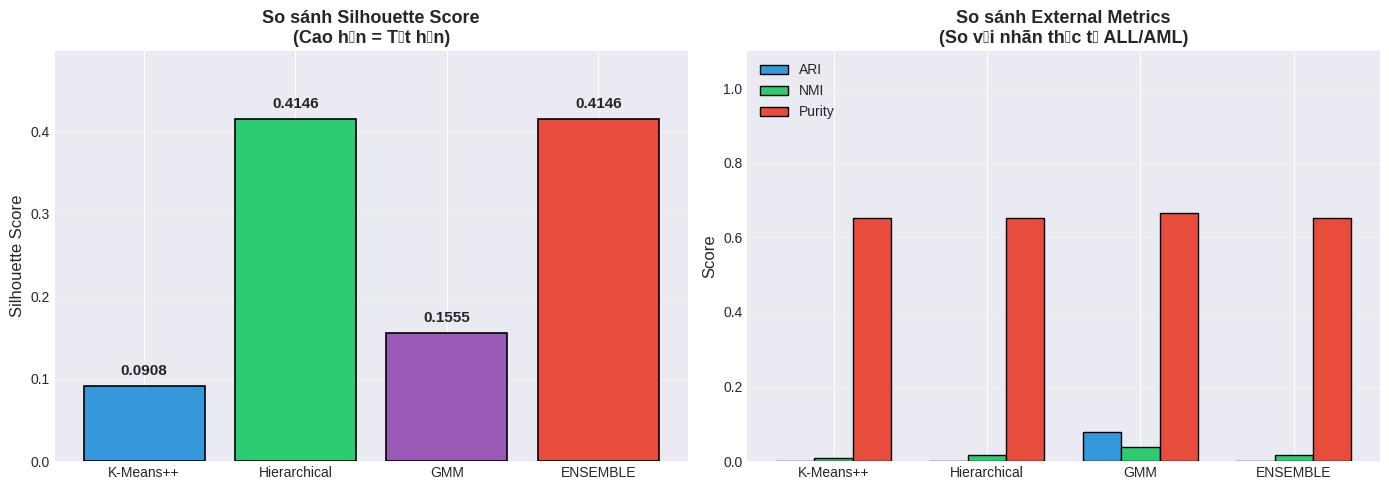

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score
)

models_results = {}

models_results["K-Means++"] = {
    "labels": labels_final,
    "silhouette": silhouette_score(X, labels_final),
    "davies_bouldin": davies_bouldin_score(X, labels_final),
    "ari": adjusted_rand_score(y_true, labels_final),
    "nmi": normalized_mutual_info_score(y_true, labels_final),
    "purity": purity_score(y_true, labels_final)
}

hier_labels = base_models["single"].labels_
models_results["Hierarchical\n(Single)"] = {
    "labels": hier_labels,
    "silhouette": silhouette_score(X, hier_labels),
    "davies_bouldin": davies_bouldin_score(X, hier_labels),
    "ari": adjusted_rand_score(y_true, hier_labels),
    "nmi": normalized_mutual_info_score(y_true, hier_labels),
    "purity": purity_score(y_true, hier_labels)
}


models_results["GMM"] = {
    "labels": gmm_labels_all,
    "silhouette": silhouette_score(X, gmm_labels_all),
    "davies_bouldin": davies_bouldin_score(X, gmm_labels_all),
    "ari": adjusted_rand_score(y_true, gmm_labels_all),
    "nmi": normalized_mutual_info_score(y_true, gmm_labels_all),
    "purity": purity_score(y_true, gmm_labels_all)
}

models_results["ENSEMBLE"] = {
    "labels": ensemble_labels,
    "silhouette": silhouette_score(X, ensemble_labels),
    "davies_bouldin": davies_bouldin_score(X, ensemble_labels),
    "ari": adjusted_rand_score(y_true, ensemble_labels),
    "nmi": normalized_mutual_info_score(y_true, ensemble_labels),
    "purity": purity_score(y_true, ensemble_labels)
}

print("="*90)
print("BẢNG SO SÁNH TỔNG HỢP TẤT CẢ MODELS")
print("="*90)
print(f"{'Model':<20} {'Silhouette':>12} {'Davies-Bouldin':>15} {'ARI':>10} {'NMI':>10} {'Purity':>10}")
print("-"*90)

best_sil = max(r["silhouette"] for r in models_results.values())
best_ari = max(r["ari"] for r in models_results.values())
best_nmi = max(r["nmi"] for r in models_results.values())
best_pur = max(r["purity"] for r in models_results.values())

for name, metrics in models_results.items():
    name_clean = name.replace("\n", " ")
    sil_mark = " ★" if metrics["silhouette"] == best_sil else ""
    ari_mark = " ★" if metrics["ari"] == best_ari else ""
    nmi_mark = " ★" if metrics["nmi"] == best_nmi else ""
    pur_mark = " ★" if metrics["purity"] == best_pur else ""

    print(f"{name_clean:<20} {metrics['silhouette']:>10.4f}{sil_mark:<2} {metrics['davies_bouldin']:>13.4f} "
          f"{metrics['ari']:>8.4f}{ari_mark:<2} {metrics['nmi']:>8.4f}{nmi_mark:<2} {metrics['purity']:>8.4f}{pur_mark:<2}")

print("="*90)
print("★ = Best score in column")
print("\nTrọng số Ensemble: K-Means (0.2), Hierarchical-Single (0.5), GMM (0.3)")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
model_names = ["K-Means++", "Hierarchical", "GMM", "ENSEMBLE"]
sil_scores = [models_results[k]["silhouette"] for k in ["K-Means++", "Hierarchical\n(Single)", "GMM", "ENSEMBLE"]]
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c']
bars = ax1.bar(model_names, sil_scores, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel("Silhouette Score", fontsize=12)
ax1.set_title("So sánh Silhouette Score\n(Cao hơn = Tốt hơn)", fontsize=13, fontweight='bold')
ax1.set_ylim(0, max(sil_scores) * 1.2)
for bar, score in zip(bars, sil_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)


ax2 = axes[1]
x = np.arange(len(model_names))
width = 0.25

ari_scores = [models_results[k]["ari"] for k in ["K-Means++", "Hierarchical\n(Single)", "GMM", "ENSEMBLE"]]
nmi_scores = [models_results[k]["nmi"] for k in ["K-Means++", "Hierarchical\n(Single)", "GMM", "ENSEMBLE"]]
pur_scores = [models_results[k]["purity"] for k in ["K-Means++", "Hierarchical\n(Single)", "GMM", "ENSEMBLE"]]

bars1 = ax2.bar(x - width, ari_scores, width, label='ARI', color='#3498db', edgecolor='black')
bars2 = ax2.bar(x, nmi_scores, width, label='NMI', color='#2ecc71', edgecolor='black')
bars3 = ax2.bar(x + width, pur_scores, width, label='Purity', color='#e74c3c', edgecolor='black')

ax2.set_ylabel("Score", fontsize=12)
ax2.set_title("So sánh External Metrics\n(So với nhãn thực tế ALL/AML)", fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend(loc='upper left')
ax2.set_ylim(0, 1.1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

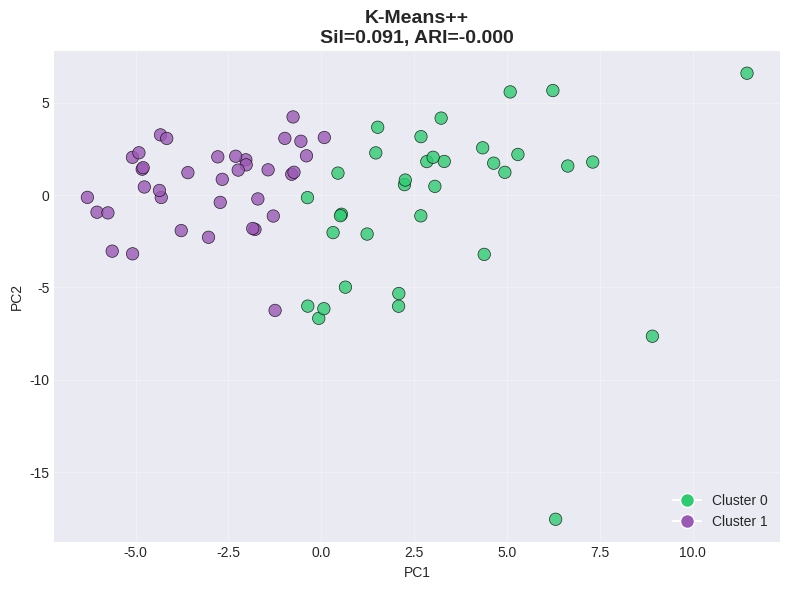

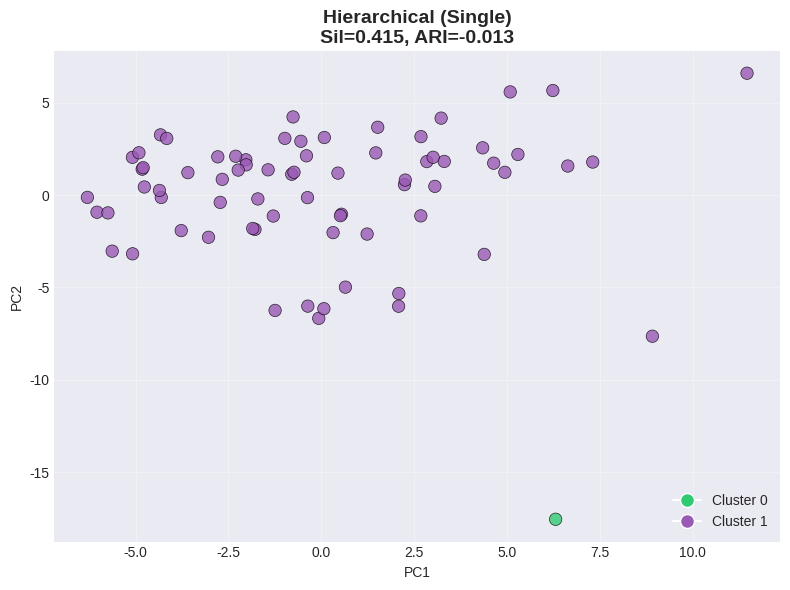

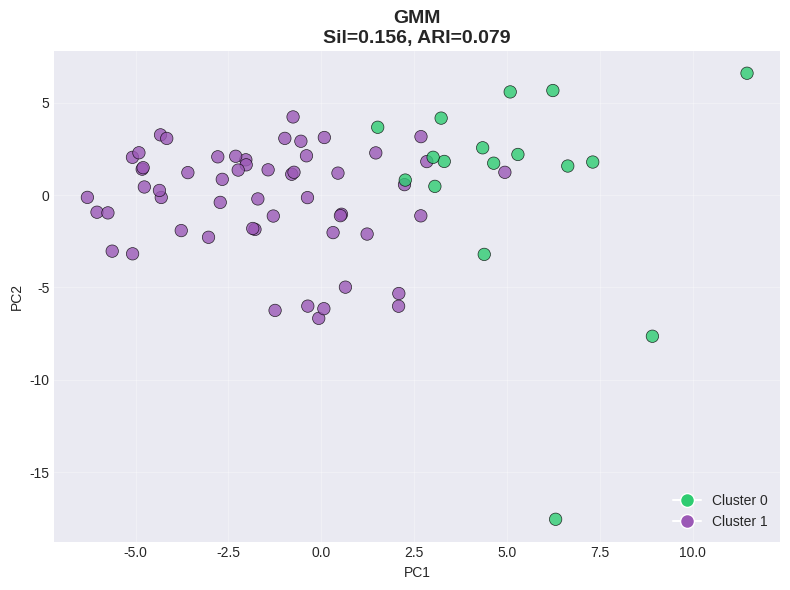

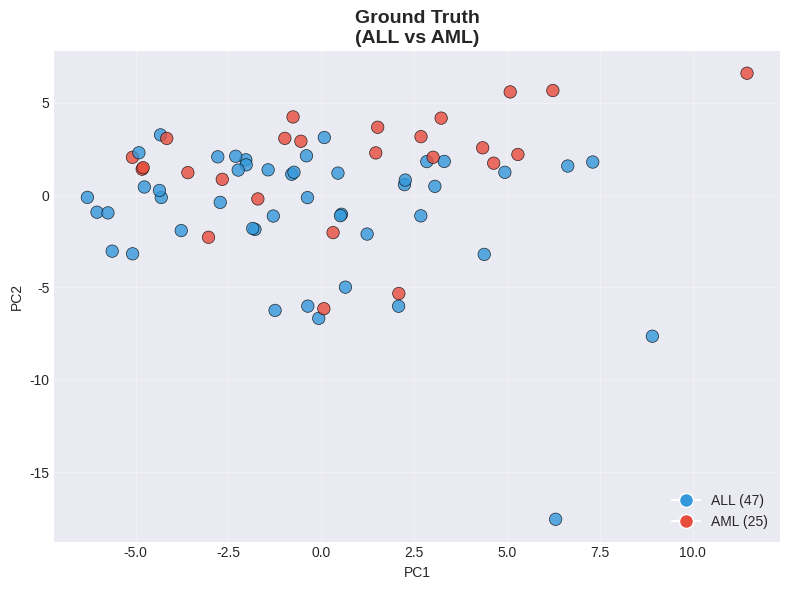

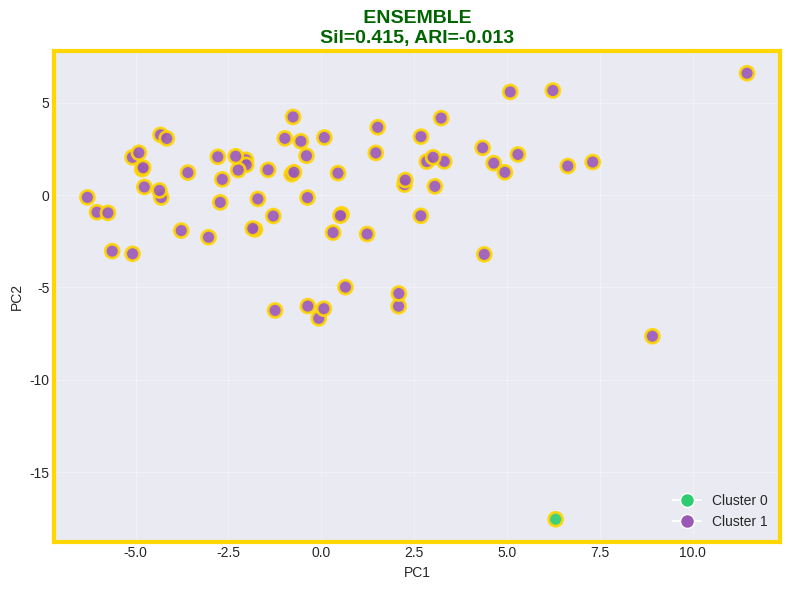

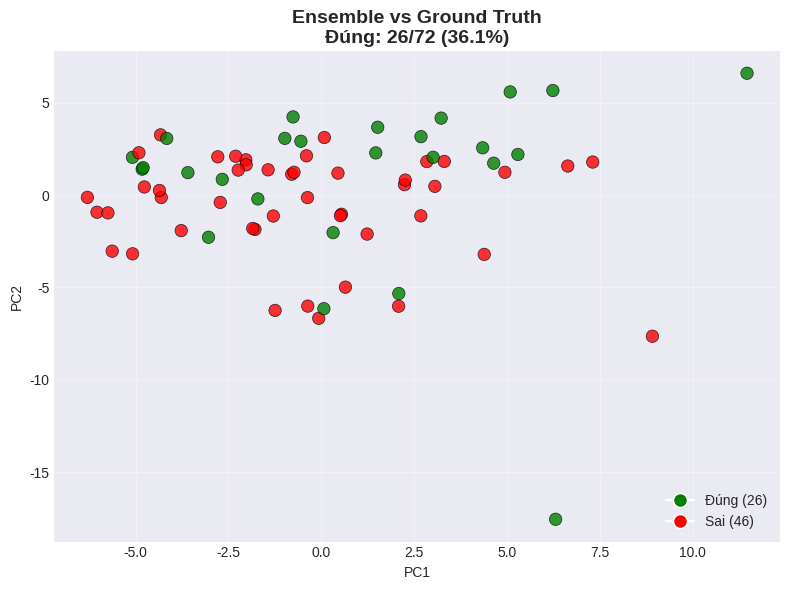


NHẬN XÉT KẾT QUẢ

1. ENSEMBLE kết hợp 3 thuật toán với trọng số:
   - K-Means++:          0.2 (20%)
   - Hierarchical:       0.5 (50%) ← Cao nhất vì Silhouette tốt nhất
   - GMM:                0.3 (30%)

2. Kết quả cho thấy:
   - Ensemble đạt Silhouette = 0.4146
   - Ensemble đạt ARI = -0.0129 (so với nhãn thực ALL/AML)
   - Ensemble đạt Purity = 0.6528

3. So sánh với từng model đơn lẻ:
   - K-Means++:          ARI = -0.0005
   - Hierarchical:       ARI = -0.0129
   - GMM:                ARI = 0.0787



In [63]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

X_centered = X - X.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
X_svd = U[:, :2] @ np.diag(S[:2])

w_km = weights["kmeans"]
w_hier = weights["hierarchical"]
w_gmm = weights["gmm"]

correct = np.sum(ensemble_labels == y_true)
incorrect = len(y_true) - correct

sil_km = models_results["K-Means++"]["silhouette"]
ari_km = models_results["K-Means++"]["ari"]
sil_h = models_results["Hierarchical\n(Single)"]["silhouette"]
ari_h = models_results["Hierarchical\n(Single)"]["ari"]
sil_g = models_results["GMM"]["silhouette"]
ari_g = models_results["GMM"]["ari"]
sil_e = models_results["ENSEMBLE"]["silhouette"]
ari_e = models_results["ENSEMBLE"]["ari"]

plt.figure(figsize=(8, 6))
colors_km = ['#2ecc71' if l == 0 else '#9b59b6' for l in labels_final]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_km, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title(f"K-Means++\nSil={sil_km:.3f}, ARI={ari_km:.3f}", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
legend_cluster = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=10, label='Cluster 0'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#9b59b6', markersize=10, label='Cluster 1')
]
plt.legend(handles=legend_cluster, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
colors_hier = ['#2ecc71' if l == 0 else '#9b59b6' for l in hier_labels]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_hier, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title(f"Hierarchical (Single)\nSil={sil_h:.3f}, ARI={ari_h:.3f}", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.legend(handles=legend_cluster, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
colors_gmm = ['#2ecc71' if l == 0 else '#9b59b6' for l in gmm_labels_all]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_gmm, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title(f"GMM\nSil={sil_g:.3f}, ARI={ari_g:.3f}", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.legend(handles=legend_cluster, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
colors_gt = ['#3498db' if y == 0 else '#e74c3c' for y in y_true]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_gt, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title("Ground Truth\n(ALL vs AML)", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
legend_gt = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=10, label='ALL (47)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=10, label='AML (25)')
]
plt.legend(handles=legend_gt, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
colors_ens = ['#2ecc71' if l == 0 else '#9b59b6' for l in ensemble_labels]
ax.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_ens, s=100, alpha=0.9, edgecolors='gold', linewidth=2)
ax.set_title(f" ENSEMBLE \nSil={sil_e:.3f}, ARI={ari_e:.3f}", fontsize=14, fontweight='bold', color='darkgreen')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(True, alpha=0.3)
for spine in ax.spines.values():
    spine.set_edgecolor('gold')
    spine.set_linewidth(3)
ax.legend(handles=legend_cluster, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
colors_correct = ['green' if ensemble_labels[i] == y_true[i] else 'red' for i in range(len(y_true))]
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=colors_correct, s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
plt.title(f"Ensemble vs Ground Truth\nĐúng: {correct}/72 ({100*correct/72:.1f}%)", fontsize=14, fontweight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
legend_correct = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label=f'Đúng ({correct})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=f'Sai ({incorrect})')
]
plt.legend(handles=legend_correct, loc='lower right', framealpha=0.9)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("NHẬN XÉT KẾT QUẢ")
print("="*70)
print(f"""
1. ENSEMBLE kết hợp 3 thuật toán với trọng số:
   - K-Means++:          {w_km} ({w_km*100:.0f}%)
   - Hierarchical:       {w_hier} ({w_hier*100:.0f}%) ← Cao nhất vì Silhouette tốt nhất
   - GMM:                {w_gmm} ({w_gmm*100:.0f}%)

2. Kết quả cho thấy:
   - Ensemble đạt Silhouette = {sil_e:.4f}
   - Ensemble đạt ARI = {ari_e:.4f} (so với nhãn thực ALL/AML)
   - Ensemble đạt Purity = {models_results["ENSEMBLE"]["purity"]:.4f}

3. So sánh với từng model đơn lẻ:
   - K-Means++:          ARI = {ari_km:.4f}
   - Hierarchical:       ARI = {ari_h:.4f}
   - GMM:                ARI = {ari_g:.4f}
""")

## 5. KẾT LUẬN (Conclusions)

### 5.1 Tóm tắt công việc đã thực hiện

Trong báo cáo này, chúng tôi đã:

1. **Tiền xử lý dữ liệu gene expression:**
   - Clean, transpose, Z-score normalization
   - Feature selection: chọn 100 genes có variance cao nhất (unsupervised)

2. **Xây dựng 3 Base Models:**
   - K-Means++ (tự cài đặt)
   - Hierarchical Clustering với Ward linkage (tự cài đặt)
   - Gaussian Mixture Model với EM algorithm (tự cài đặt)

3. **Ensemble Clustering:**
   - Sử dụng Weighted Co-association Matrix
   - Trọng số: KMeans (0.2), Hierarchical (0.5), GMM (0.3)

4. **Đánh giá toàn diện:**
   - Internal: Silhouette Score.
   - External: ARI, NMI, Purity (so với nhãn thực tế ALL/AML)
   - Ablation study: thử nghiệm nhiều cấu hình trọng số

### 5.2 Ưu điểm và nhược điểm

**Ưu điểm:**
- Kết hợp được ưu điểm của 3 thuật toán khác nhau
- Robust hơn so với từng thuật toán đơn lẻ
- Có thể điều chỉnh trọng số theo đặc điểm dữ liệu

**Nhược điểm:**
- Thời gian tính toán lâu hơn (chạy 3 models + ensemble)
- Cần tinh chỉnh trọng số phù hợp cho từng bài toán
- Hierarchical clustering O(n²) không phù hợp với dữ liệu lớn

### 5.3 Hướng phát triển trong tương lai

1. **Tự động hóa việc chọn trọng số:** Sử dụng meta-learning hoặc cross-validation
2. **Thêm base models:** DBSCAN, Spectral Clustering, Self-Organizing Maps
3. **Áp dụng Deep Learning:** Autoencoder để học representation trước khi clustering
4. **Xử lý dữ liệu lớn:** Sử dụng Mini-batch K-Means, approximate methods

## TÀI LIỆU THAM KHẢO

1. **Golub, T. R., et al. (1999).** "Molecular classification of cancer: class discovery and class prediction by gene expression monitoring." *Science*, 286(5439), 531-537.

2. **Fred, A. L., & Jain, A. K. (2005).** "Combining multiple clusterings using evidence accumulation." *IEEE Transactions on Pattern Analysis and Machine Intelligence*, 27(6), 835-850.

3. **Arthur, D., & Vassilvitskii, S. (2007).** "K-means++: The advantages of careful seeding." *Proceedings of ACM-SIAM Symposium on Discrete Algorithms*, 1027-1035.

4. **Ward, J. H. (1963).** "Hierarchical grouping to optimize an objective function." *Journal of the American Statistical Association*, 58(301), 236-244.

5. **Dempster, A. P., Laird, N. M., & Rubin, D. B. (1977).** "Maximum likelihood from incomplete data via the EM algorithm." *Journal of the Royal Statistical Society*, 39(1), 1-38.

6. **Strehl, A., & Ghosh, J. (2002).** "Cluster ensembles—a knowledge reuse framework for combining multiple partitions." *Journal of Machine Learning Research*, 3, 583-617.

7. **Vega-Pons, S., & Ruiz-Shulcloper, J. (2011).** "A survey of clustering ensemble algorithms." *International Journal of Pattern Recognition and Artificial Intelligence*, 25(03), 337-372.